# TPC DS scale factor 10 - Apache Spark acceleration on GPU with RAPIDS Spark

based on https://colab.research.google.com/github/LucaCanali/Miscellaneous/blob/master/Performance_Testing/TPCDS_PySpark/Labs_and_Notes/TPCDS_PySpark_getstarted.ipynb#scrollTo=6bab7772

# Download TPC-DS 10GiB Scale Parquet Dataset

In [21]:
!pip install --quiet tpcds_pyspark pyspark==3.5.0 sparkmeasure pandas matplotlib

In [2]:
import os
from importlib.resources import files
from pyspark.sql import SparkSession
from tpcds_pyspark import TPCDS
import pandas as pd

In [3]:
tpcds_pyspark_files = files('tpcds_pyspark')

In [4]:
if not os.path.isdir('tpcds_10'):
  if not os.path.isfile('tpcds_10.zip'):
    !wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/TPCDS/tpcds_10.zip
  !unzip -q tpcds_10.zip

--2024-10-18 20:38:45--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/TPCDS/tpcds_10.zip
Resolving sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)... 2001:1458:d00:62::100:2e8, 2001:1458:d00:16::41d, 2001:1458:d00:65::100:265, ...
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|2001:1458:d00:62::100:2e8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2888130422 (2.7G) [application/zip]
Saving to: ‘tpcds_10.zip’

tpcds_10.zip        100%[===================>]   2.69G   747KB/s    in 42m 2s  

2024-10-18 21:20:47 (1.09 MB/s) - ‘tpcds_10.zip’ saved [2888130422/2888130422]



# Init a SparkSession with RAPIDS Spark

In [5]:
spark = (
    SparkSession.builder
      .appName('TPCDS PySpark RAPIDS=ON/OFF')
      .config('spark.driver.memory', '5g')
      .config('spark.plugins', 'com.nvidia.spark.SQLPlugin')
      .config('spark.jars', tpcds_pyspark_files.joinpath('spark-measure_2.12-0.24.jar'))
      .config('spark.jars.packages', 'com.nvidia:rapids-4-spark_2.12:24.08.0')
      .getOrCreate()
)


24/10/18 21:22:37 WARN Utils: Your hostname, 73d57f4-lcelt resolves to a loopback address: 127.0.1.1; using 192.168.1.209 instead (on interface wlp0s20f3)
24/10/18 21:22:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/gshegalov/.local/share/virtualenvs/jupyter-juFhdvmw/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/gshegalov/.ivy2/cache
The jars for the packages stored in: /home/gshegalov/.ivy2/jars
com.nvidia#rapids-4-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-20d06318-4840-46bb-9dec-770127812d79;1.0
	confs: [default]
	found com.nvidia#rapids-4-spark_2.12;24.08.0 in central
:: resolution report :: resolve 84ms :: artifacts dl 3ms
	:: modules in use:
	com.nvidia#rapids-4-spark_2.12;24.08.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-20d06318-4840-46bb-9dec-

# Verify SQL Acceleration on GPU can be enabled by checking the query plan and the GPU RAM in the "Resources" tab

In [6]:
spark.conf.set('spark.rapids.sql.enabled', True)
sum_df = spark.range(1000).selectExpr('SUM(*)')
sum_df.collect()
sum_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=22]
   +- GpuHashAggregate (keys=[], functions=[gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=21]
      +- GpuShuffleCoalesce 1073741824, [loreId=20]
         +- ShuffleQueryStage 0
            +- GpuColumnarExchange gpusinglepartitioning$(), ENSURE_REQUIREMENTS, [plan_id=64], [loreId=17]
               +- GpuHashAggregate (keys=[], functions=[partial_gpubasicsum(id#0L, LongType, false)]), filters=ArrayBuffer(None)) [loreId=16]
                  +- GpuRange (0, 1000, step=1, splits=16)
+- == Initial Plan ==
   HashAggregate(keys=[], functions=[sum(id#0L)])
   +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [plan_id=11]
      +- HashAggregate(keys=[], functions=[partial_sum(id#0L)])
         +- Range (0, 1000, step=1, splits=16)




In [7]:
# https://github.com/LucaCanali/Miscellaneous/tree/master/Performance_Testing/TPCDS_PySpark/tpcds_pyspark/Queries

# queries = None to run all (takes much longer)
queries = None
queries = [
    'q14a',
    'q14b',
    'q23a',
    'q23b',
    'q24a',
    'q24b',
    'q88',
]


In [8]:
tpcds = TPCDS(data_path="./tpcds_10", num_runs=1, queries_repeat_times=1, queries=queries)

sparkMeasure jar path: /home/gshegalov/.local/share/virtualenvs/jupyter-juFhdvmw/lib/python3.10/site-packages/tpcds_pyspark/spark-measure_2.12-0.24.jar
TPCDS queries path: /home/gshegalov/.local/share/virtualenvs/jupyter-juFhdvmw/lib/python3.10/site-packages/tpcds_pyspark/Queries


24/10/18 21:23:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Register TPC-DS tables before running queries

In [9]:
tpcds.map_tables()

Creating temporary view catalog_returns


24/10/18 21:23:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Creating temporary view catalog_sales
Creating temporary view inventory
Creating temporary view store_returns
Creating temporary view store_sales
Creating temporary view web_returns
Creating temporary view web_sales
Creating temporary view call_center
Creating temporary view catalog_page
Creating temporary view customer
Creating temporary view customer_address
Creating temporary view customer_demographics
Creating temporary view date_dim
Creating temporary view household_demographics
Creating temporary view income_band
Creating temporary view item
Creating temporary view promotion
Creating temporary view reason
Creating temporary view ship_mode
Creating temporary view store
Creating temporary view time_dim
Creating temporary view warehouse
Creating temporary view web_page
Creating temporary view web_site


# Measure Apache Spark CPU

In [10]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', False)
tpcds.run_TPCDS()


Run 0 - query q14a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:23:22
...Elapsed Time = 15.19 sec
...Executors Run Time = 150.58 sec
...Executors CPU Time = 92.16 sec
...Executors JVM GC Time = 13.13 sec
...Average Active Tasks = 9.9

Run 0 - query q14b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:23:42
...Elapsed Time = 8.47 sec
...Executors Run Time = 99.93 sec
...Executors CPU Time = 73.23 sec
...Executors JVM GC Time = 10.54 sec
...Average Active Tasks = 11.8

Run 0 - query q23a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:23:53
...Elapsed Time = 14.36 sec
...Executors Run Time = 170.7 sec
...Executors CPU Time = 123.13 sec
...Executors JVM GC Time = 21.74 sec
...Average Active Tasks = 11.9

Run 0 - query q23b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:24:08
...Elapsed Time = 15.41 sec
...Executors Run Time = 186.21 sec
...Executors CPU Time = 139.25 sec
...Executors JVM GC Time = 24.15 sec
...Average Active Tasks = 12.1

Run 0 - query q24a - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:24:25
...Elapsed Time = 6.42 sec
...Executors Run Time = 64.95 sec
...Executors CPU Time = 47.44 sec
...Executors JVM GC Time = 9.83 sec
...Average Active Tasks = 10.1

Run 0 - query q24b - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:24:33
...Elapsed Time = 4.72 sec
...Executors Run Time = 41.43 sec
...Executors CPU Time = 30.29 sec
...Executors JVM GC Time = 7.35 sec
...Average Active Tasks = 8.8

Run 0 - query q88 - attempt 0 - starting...


Job finished
...Start Time = 2024-10-18 21:24:38
...Elapsed Time = 2.6 sec
...Executors Run Time = 36.08 sec
...Executors CPU Time = 26.18 sec
...Executors JVM GC Time = 1.8 sec
...Average Active Tasks = 13.9


In [11]:
cpu_grouped_results = tpcds.grouped_results_pdf[['query', 'elapsedTime']].copy()

In [12]:
cpu_grouped_results

,query,elapsedTime
0,q14a,15186
1,q14b,8474
2,q23a,14360
3,q23b,15411
4,q24a,6415
5,q24b,4717
6,q88,2603


# Measure Apache Spark GPU

In [13]:
tpcds.spark.conf.set('spark.rapids.sql.enabled', True)
tpcds.run_TPCDS()


Run 0 - query q14a - attempt 0 - starting...


24/10/18 21:25:12 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:09
...Elapsed Time = 7.13 sec
...Executors Run Time = 44.7 sec
...Executors CPU Time = 15.58 sec
...Executors JVM GC Time = 2.54 sec
...Average Active Tasks = 6.3

Run 0 - query q14b - attempt 0 - starting...


24/10/18 21:25:21 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:20
...Elapsed Time = 3.09 sec
...Executors Run Time = 28.9 sec
...Executors CPU Time = 12.01 sec
...Executors JVM GC Time = 0.92 sec
...Average Active Tasks = 9.3

Run 0 - query q23a - attempt 0 - starting...


24/10/18 21:25:25 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:25
...Elapsed Time = 3.74 sec
...Executors Run Time = 39.08 sec
...Executors CPU Time = 16.68 sec
...Executors JVM GC Time = 1.02 sec
...Average Active Tasks = 10.4

Run 0 - query q23b - attempt 0 - starting...


24/10/18 21:25:30 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:30
...Elapsed Time = 4.32 sec
...Executors Run Time = 47.85 sec
...Executors CPU Time = 18.25 sec
...Executors JVM GC Time = 1.54 sec
...Average Active Tasks = 11.1

Run 0 - query q24a - attempt 0 - starting...


24/10/18 21:25:36 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:36
...Elapsed Time = 3.23 sec
...Executors Run Time = 24.03 sec
...Executors CPU Time = 8.63 sec
...Executors JVM GC Time = 0.69 sec
...Average Active Tasks = 7.4

Run 0 - query q24b - attempt 0 - starting...


24/10/18 21:25:40 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:40
...Elapsed Time = 3.04 sec
...Executors Run Time = 21.31 sec
...Executors CPU Time = 8.02 sec
...Executors JVM GC Time = 0.67 sec
...Average Active Tasks = 7.0

Run 0 - query q88 - attempt 0 - starting...


24/10/18 21:25:45 WARN GpuOverrides: 
! <OverwriteByExpressionExec> cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.datasources.v2.OverwriteByExpressionExec



Job finished
...Start Time = 2024-10-18 21:25:44
...Elapsed Time = 1.4 sec
...Executors Run Time = 17.36 sec
...Executors CPU Time = 2.49 sec
...Executors JVM GC Time = 0.32 sec
...Average Active Tasks = 12.4


# Show Speedup Factors achieved by GPU


In [14]:
gpu_grouped_results = tpcds.grouped_results_pdf[['query', 'elapsedTime']].copy()

In [15]:
gpu_grouped_results

,query,elapsedTime
0,q14a,7132
1,q14b,3092
2,q23a,3740
3,q23b,4318
4,q24a,3234
5,q24b,3035
6,q88,1395


In [16]:
res = pd.merge(cpu_grouped_results, gpu_grouped_results, on='query', how='inner', suffixes=['_cpu', '_gpu'])

In [17]:
res['speedup'] = res['elapsedTime_cpu'] / res['elapsedTime_gpu']

In [18]:
res = res.sort_values(by='elapsedTime_cpu', ascending=False)

<Axes: title={'center': 'TPC-DS query elapsedTime on CPU vs GPU (lower is better)'}, xlabel='query'>

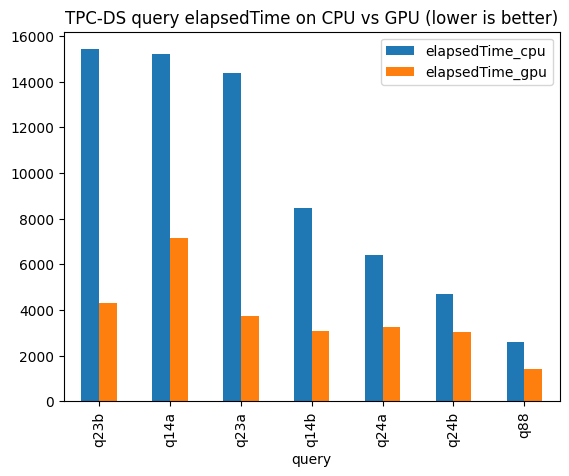

In [22]:
res.plot(title='TPC-DS query elapsedTime on CPU vs GPU (lower is better)', kind='bar', x='query', y=['elapsedTime_cpu', 'elapsedTime_gpu'])

<Axes: title={'center': 'Speedup factors of TPC-DS queries on GPU'}, xlabel='query'>

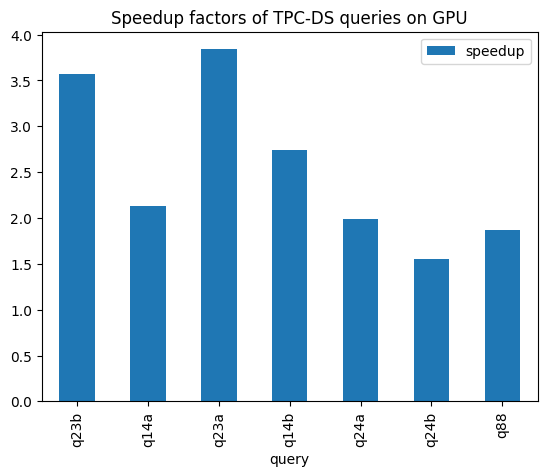

In [23]:
res.plot(title='Speedup factors of TPC-DS queries on GPU', kind='bar', x='query', y='speedup' )

# Run Queries interactively

In [26]:
query = 'q88'
with open(f"{tpcds_pyspark_files}/Queries/{query}.sql") as f:
  q = f.read()

In [28]:
print(q)

SELECT *
FROM
  (SELECT count(*) h8_30_to_9
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 8
    AND time_dim.t_minute >= 30
    AND (
    (household_demographics.hd_dep_count = 4 AND household_demographics.hd_vehicle_count <= 4 + 2)
      OR
      (household_demographics.hd_dep_count = 2 AND household_demographics.hd_vehicle_count <= 2 + 2)
      OR
      (household_demographics.hd_dep_count = 0 AND
        household_demographics.hd_vehicle_count <= 0 + 2))
    AND store.s_store_name = 'ese') s1,
  (SELECT count(*) h9_to_9_30
  FROM store_sales, household_demographics, time_dim, store
  WHERE ss_sold_time_sk = time_dim.t_time_sk
    AND ss_hdemo_sk = household_demographics.hd_demo_sk
    AND ss_store_sk = s_store_sk
    AND time_dim.t_hour = 9
    AND time_dim.t_minute < 30
    AND (
    (household_demographics.hd_

In [29]:
spark.conf.set('spark.rapids.sql.enabled', True)
df  = spark.sql(q)
df.collect()

[Row(h8_30_to_9=18440, h9_to_9_30=39156, h9_30_to_10=38666, h10_to_10_30=58037, h10_30_to_11=58313, h11_to_11_30=34436, h11_30_to_12=33322, h12_to_12_30=39142)]

In [30]:
df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   GpuColumnarToRow false, [loreId=1466]
   +- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h12_to_12_30#71709L], 1073741824, [loreId=1465]
      :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h11_30_to_12#71708L], 1073741824, [loreId=1464]
      :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h11_to_11_30#71707L], 1073741824, [loreId=1463]
      :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h10_30_to_11#71706L], 1073741824, [loreId=1462]
      :  :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h10_to_10_30#71705L], 1073741824, [loreId=1461]
      :  :  :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h9_30_to_10#71704L], 1073741824, [loreId=1460]
      :  :  :  :  :  :- GpuBroadcastNestedLoopJoin Inner, GpuBuildRight, [h9_to_9_30#71703L], 1073741824, [loreId=1459]
      :  :  :  :  :  :  :- GpuHashAggregate (keys=[], functions=[gpucount(1, false)]), filters=L

In [31]:
spark.conf.set('spark.rapids.sql.enabled', False)
df  = spark.sql(q)
df.collect()

[Row(h8_30_to_9=18440, h9_to_9_30=39156, h9_30_to_10=38666, h10_to_10_30=58037, h10_30_to_11=58313, h11_to_11_30=34436, h11_30_to_12=33322, h12_to_12_30=39142)]